In [1]:
%run ../widgets/config_check.py

In [2]:
#The interactive plots are created by using the libraries bqplot and ipywidgets
import matplotlib.pyplot as plt
import numpy as np

from jupyter_cms.loader import load_notebook
lrw = load_notebook('../widgets/LinRegWidget.ipynb')

# Linear Regression

Linear regression is a standard tool in statistics and machine learning expressing a linear relationship between several independent $\mathbf{x} = x_1, \ldots, x_D$ and a dependent variable $y$:
$$ y = w_0 + \sum_{i = 1}^D w_i x_i + \epsilon $$
where $\epsilon$ denotes the residual error of the model.

In practice, a data set $\mathbf{D} = \{(\mathbf{x}_n, t_n)\}_{n = 1}^N$ containing $N$ training examples is usually available. The linear regression weights are then found by minimizing the squared error between model predictions and actual target outputs, i.e.
$$ w_{LR} = \mathtt{argmin}_{\mathbf{w}} \frac{1}{2} \sum_{n=1}^N (w_0 + \sum_i w_i x_{ni} - t_n)^2 $$
In the terminology of machine learning, linear regression is an example of supervised learning with continuous targets.

Linear regression can be conveniently expressed in matrix notation:
$$ y = \mathbf{w}^T \mathbf{x} + \mathbf{\epsilon} $$
where $\mathbf{w}^T$ denotes the transpose of the weight vector and $\mathbf{x}$ is assumed to be extended with $x_0 \equiv 1$. Then, the above minimization problem can be written as
$$ w_{LR} = \mathtt{argmin}_{\mathbf{w}} \frac{1}{2} \sum_{n=1}^N (t_n - \mathbf{w}^T \mathbf{x}_n)^2 $$
The optimal weight vector can be found analytically by taking the derivative and setting it to zero:
\begin{eqnarray*}
  \frac{\partial}{\partial w_i} \frac{1}{2} \sum_{n=1}^N (t_n - \mathbf{w}^T \mathbf{x}_n)^2 & = & 
  \sum_{n=1}^N (t_n - \mathbf{w}^T \mathbf{x}_n) x_{in} \overset{!}{=} 0  \quad \forall i \\
  \implies {\mathbf{w}_{LR}}^T \left( \sum_{n=1}^N \mathbf{x}_n \mathbf{x}_n^T \right) & = & \sum_{i=1}^N t_n       \mathbf{x}_n^T \\
  \mathbf{w}_{LR} & = & (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{t}
\end{eqnarray*}
where all training samples have been collected into the design matrix $\mathbf{X} = (\mathbf{x}_1^T, \ldots, \mathbf{x}_N^T) \in \mathbb{R}^{N \times (D+1)}$ and target vector $\mathbf{t} = (t_1, \ldots, t_N)^T$.

Roughly following the API of sklearn, linear regression can be implemented in Python as follows:

In [3]:
class LinearRegression:
    """
    Simple linear regression
    """
    
    def __init__(self):
        """
        Create a linear regression model
        t = X w
        
        that minimizes
        ||X w - t||_2
        """
        self.weights_ = None
        
    def fit(self, X, t):
        """
        Fit linear model on training data D = (X, t)
        """
        num_samples, num_features = X.shape
        self.weights_ = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, t))
        
        return self
    
    def predict(self, X):
        """
        Predict model response on inputs X
        """
        num_samples, num_features = X.shape
        
        return np.dot(X, self.weights_)

Note that instead of computing the matrix $(\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T$, also called *pseudo-inverse* of $\mathbf{X}$, we solve the linear system of equations $\mathbf{w}_{LR}^T (\mathbf{X}^T \mathbf{X}) = \mathbf{X}^T \mathbf{t}$ as matrix inversion is numerically rather unstable.

We can now test our linear regression class on a simple example data set ...

[-0.97548249  1.87577159]


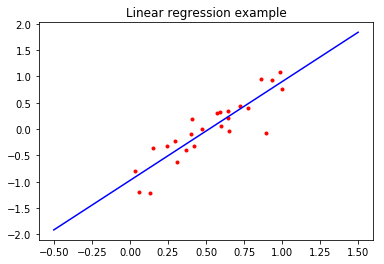

In [4]:
N = 25
x = np.random.uniform(size = N)
t = 2 * x - 1 + np.random.normal(loc = 0, scale = 0.3, size = N)
## Create design matrix with x_0 = 1
X = np.hstack((np.ones((N,1)), x[:, None]))
lm = LinearRegression()
lm.fit(X, t)
print(lm.weights_)
## Show training data and model predictions
x_pred = np.linspace(-0.5, 1.5, 251)
X_pred = np.hstack((np.ones((len(x_pred), 1)), x_pred[:, None]))
y_pred = lm.predict(X_pred)

plt.plot(x, t, 'r.');
plt.plot(x_pred, y_pred, 'b-');
plt.title("Linear regression example");

Linear regression can easily be generalized to model non-linear relationships using *basis functions* $\Phi_i(\mathbf{x}), i = 0, \ldots, M$:
$$ y = \sum_{i=0}^M \Phi_i(\mathbf{x}) + \epsilon $$
Common choices of basis functions include
* Polynomials, i.e. $\Phi_i(x) = x^i$
* Radial basis functions, i.e. $\Phi_i(x) = e^{- \frac{1}{2} \frac{(x -
        \mu_i)^2}{\sigma_i^2}}$
        
As before the intercept is conviently included by choosing $\Phi_0(\mathbf{x}) \equiv 1$.

Again, roughly following the API of sklearn linear regression with basis functions can be implemented as a preprocessing pipeline, i.e. the data are first changed -- via some basis functions -- before they are passed on to an actual model.

In [5]:
class InterceptFeature:
    """
    Constant intercept feature
    """
    def transform(self, x):
        return np.hstack([np.ones((x.shape[0], 1)), x])

class PolynomialFeatures:
    """
    Polynomial features
    """
    def __init__(self, degree):
        self.__degree = degree
    
    def transform(self, x):
        """
        Compute features x**i for i = 0, ..., degree
        """
        return np.hstack([x**i for i in range(self.__degree + 1)])
    
class GaussianBasisFunctions():
    """
    Transform the input with a gaussian function of the form:
    phi = exp(- kernelsize(=500) * (phi - mu) ** 2)
    """
    def __init__(self, mus, sigma = 1.0):
        self.mus = mus
        self.sigma = sigma
      
    def transform(self, X):
        phi = np.repeat(X,np.shape(self.mus)[0], axis = 1)
        phi_trans = phi.T - self.mus
        phi_trans = np.exp(- 0.5 / self.sigma**2 * phi_trans.T**2)
        return phi_trans    
    
class Pipeline:
    """
    Model pipeline of preprocessing steps and actual model
    """
    def __init__(self, steps):
        self.steps = steps
    def fit(self, X, y):
        for step in self.steps[:-1]:
            X = step.transform(X)
        ## Last step of pipeline is actual model
        self.steps[-1].fit(X, y)
        return self
    def predict(self, X):
        for step in self.steps[:-1]:
            X = step.transform(X)
        return self.steps[-1].predict(X)

These basis functions then transform the original input data $\mathbf{x}$ and the linear regression is based on the values $\Phi_1(\mathbf{x}), \ldots, \Phi_M(\mathbf{x})$ instead. Below an example with $x \in \mathbb{R}$ is shown:
* Polynomial basis functions $\Phi_i(x) = x^i$ for $i = 0, 1, 2, 3$
* Radial basis functions $\Phi_i(x) = e^{- \frac{1}{2} \frac{(x - \mu_i)^2}{\sigma^2}}$ with $\mu_1 = -1, \mu_2 = 0, \mu_3 = 1$ and width $\sigma = 0.4$
The regression for the point $x = 0.25$ is then based on the output of the corresponding basis functions (marked with a dot in the figure).

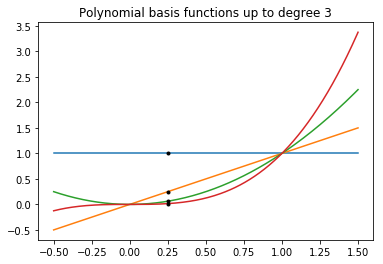

In [6]:
plt.plot(x_pred, PolynomialFeatures(3).transform(x_pred[:, None]), '-');
xp = np.array([[0.25]])
plt.plot(xp, PolynomialFeatures(3).transform(xp), 'k.')
plt.title("Polynomial basis functions up to degree 3");

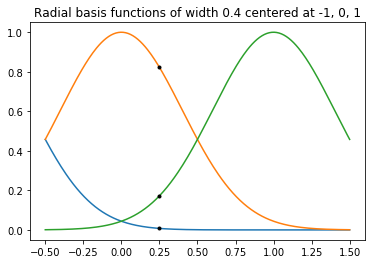

In [7]:
mus = np.array([-1, 0, 1])[:, None]
plt.plot(x_pred, GaussianBasisFunctions(mus = mus, sigma = 0.4).transform(x_pred[:, None]), '-');
plt.plot(xp, GaussianBasisFunctions(mus = mus, sigma = 0.4).transform(xp), 'k.');
plt.title("Radial basis functions of width 0.4 centered at -1, 0, 1");

Now, using 8 radial basis functions equally spaced between -1 and 1, a non-linear regression line can be computed for the original example data.
Note that the model starts to fits noise in the data as we know that the data where generated with a true linear relationship. Especially when extrapolating this leads to wrong predictions.

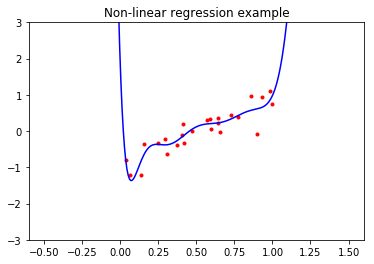

In [8]:
nlm = Pipeline([GaussianBasisFunctions(np.linspace(-1, 1, 8)[:, None], sigma = 0.4),
                InterceptFeature(), ## add constant basis function
                LinearRegression()])
nlm.fit(x[:, None], t)
## Show training data and model predictions
y_pred = nlm.predict(x_pred[:, None])

plt.plot(x, t, 'r.');
plt.plot(x_pred, y_pred, 'b-');
plt.ylim(-3, 3);
plt.title("Non-linear regression example");

To get a feeling for the role of different basis functions, we create several example data sets and an interactive plot  that allows to choose different options:

In [9]:
plot = lrw.LinRegWidget(L2=False)
plot.show()

Note that with flexible models, i.e. polynomial of high degree or radial basis functions with small lengthscale, the fit is very sensitive to single data points. This is known as over-fitting as the model starts to fit noise in the data. In order to enable reasonable fits even with flexible models, we need to control the complexity of the model.

A simple and widely used technique to control model complexity is regularization. Here, instead of minimizing the squared error between model predictions and data points, a penalized error function is used:
$$ w_{L2} = \mathtt{argmin}_{\mathbf{w}} \frac{1}{2} \sum_{n=1}^N (t_n - \mathbf{w}^T \mathbf{x}_n)^2 + \frac{\lambda}{2} || \mathbf{w} ||_2 $$
Thus, large weights are disfavored by penalizing the L2 norm of the weight vector, i.e. $|| \mathbf{w} ||_2 = \sum_i w_i^2$.

Exercise: Compute the optimal weight vector $\mathbf{w}_{L2}$.

In [10]:
class LinearRegressionL2:
    """
    Linear regression with L2 regularization
    """
    
    def __init__(self, lam):
        """
        Create a linear regression model
        t = X w
        
        that minimizes
        ||X w - t||_2 + \\lambda || w ||_2
        """
        self.weights_ = None
        self.lambda_ = lam
        
    def fit(self, X, t):
        """
        Fit linear model on training data D = (X, t)
        """
        num_samples, num_features = X.shape
        self.weights_ = np.linalg.solve(np.dot(X.T, X) + self.lambda_ * np.identity(num_features),
                                        np.dot(X.T, t))
        
        return self
    
    def predict(self, X):
        """
        Predict model response on inputs X
        """
        num_samples, num_features = X.shape
        
        return np.dot(X, self.weights_)

In [13]:
plotL2 = lrw.LinRegWidget(L2=False)
plotL2.show()

Now, using a regularized fit we can fit much more flexible models without being overly sensitive to single data points. A theoretical explanations of why this is the case can be given in terms of the *bias-variance decomposition*. Here, instead we consider Bayesian linear regression as an alternative, principled way to control model complexity.